# Analysis of current model rewards

In [276]:
import pandas as pd
from pymongo import MongoClient
from datetime import datetime, timedelta

from steem import Steem
from steem.post import Post
from steembase.exceptions import PostDoesNotExist

import matplotlib.pyplot as plt

%matplotlib notebook

# client = MongoClient('mongodb://107.155.87.82:26999')
client = MongoClient('mongodb://localhost:26999')
db = client.get_database('steem_posts')
db.authenticate("admin","dmw]SR%u6Ct!", source='admin')
past_votes_col = db.get_collection('past_votes')


steemd_instance = Steem(nodes=['https://api.steemit.com']).steemd

def get_percent_hr1(post):
#     sorted_votes = sorted(post.active_votes, key=lambda x: datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S'))
    total_weight = 0
    hr1_weight = pd.np.nan
    hr1_strength = 0
    for vote in post.active_votes:
        weight = vote['weight']
        total_weight += weight
        
        if vote['voter'] == 'hr1':
            hr1_weight = weight
            hr1_strength = vote['percent']
    
    if hr1_weight is pd.np.nan:
        print(post.identifier)
        total_weight = 1
    
    if total_weight == 0:
        total_weight = 1 # all votes might be zero, but then hr1_weight must by NaN, so it's ok
    
    return hr1_weight / total_weight, hr1_strength

def get_payout_hr1(identifier):
    try:
        post = Post(identifier, steemd_instance=steemd_instance)
    except (TypeError, PostDoesNotExist):
        print("Doesn't exist: %s" % identifier)
        return pd.np.nan, pd.np.nan, pd.np.nan, pd.np.nan
    
    percent, strength = get_percent_hr1(post)
    
    if post.curator_payout_value > 0:
        # reward already paid out
        pending = False
        payout = post.curator_payout_value
        total_payout = post.reward + post.curator_payout_value
    else:
        # pending payout
        pending = True
        payout = post.pending_payout_value * 0.25 # curators get 25% from the post reward
        total_payout = post.pending_payout_value.amount # SBD
        
    return payout * percent, strength, pending, total_payout

def download_payouts_and_strengths(last_week_votes_df):
    now = datetime.utcnow()

    payouts_hr1 = []
    used_strength_hr1 = []
    is_pending = []
    total_payouts = []
    
    for i, identifier in enumerate(last_week_votes_df['_id']):
        if i % 50 == 0:
            print('%d (%d%%)' % (i, 100 * i / last_week_votes_df.shape[0]))

        payout_hr1, strength_hr1, pending, total_payout = get_payout_hr1(identifier)
        
        payouts_hr1.append(payout_hr1)
        used_strength_hr1.append(strength_hr1)
        is_pending.append(pending)
        total_payouts.append(total_payout)

    print('done')
    last_week_votes_df['strength'] = used_strength_hr1
    last_week_votes_df['hr1_%s' % now] = [float(x) for x in payouts_hr1]
    last_week_votes_df['pending'] = is_pending
    last_week_votes_df['total_payout'] = total_payouts
    
    return last_week_votes_df.dropna()

def get_payout_stats(last_week_votes_df, pending=None, days=None):
    
    print(datetime.utcnow(), '\n')
    
    if pending is not None:
        last_week_votes_df = last_week_votes_df[last_week_votes_df['pending'] == pending]
        
    if days:
        start_time = datetime.utcnow() - timedelta(days=days)
        last_week_votes_df = last_week_votes_df[last_week_votes_df['vote_time'] >= start_time]
        
        if start_time < start_time_model:
            time_diff = (datetime.utcnow() - start_time_model).total_seconds()
            time_diff = time_diff / 3600 / 24
        else:
            time_diff = days
    else:
        time_diff = (last_week_votes_df['vote_time'].max() - last_week_votes_df['vote_time'].min()).total_seconds()
        time_diff = time_diff / 3600 / 24
    
    last_col_name = last_week_votes_df.columns[-3]
#     last_col_name = last_week_votes_df.columns[-1]
    total_payout = last_week_votes_df[last_col_name].sum()
    
    avg_daily = total_payout / time_diff
    avg_weekly = avg_daily * 7
    avg_monthly = avg_weekly * 4
    avg_yearly = avg_monthly * 12
    
    print('Total payout in given period (%.1fd): %.3f SBD \t (avg. upvoted post payout: %.3f)' % 
          (time_diff, total_payout, last_week_votes_df.total_payout.mean()))
    print('Avg. daily payout: %.3f SBD' % (avg_daily))
    print('Avg. weekly payout: %.3f SBD' % (avg_weekly))
    print('Avg. monthly (28d) payout: %.3f SBD' % (avg_monthly))
    print('Avg. yearly (364d) payout: %.3f SBD' % (avg_yearly))

## Results for model deployed on 2017-12-17 20:33 UTC

In [277]:
# start_time_model = datetime.utcnow() - timedelta(days=7)
# start_time_model = datetime.strptime('2017-10-26T15:33', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.strptime('2017-11-27T13:35', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.strptime('2017-12-17T20:33', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.strptime('2018-01-22T09:58', '%Y-%m-%dT%H:%M')

# start of vote-count experiment
# start_time_model = datetime.strptime('2018-03-02T17:10', '%Y-%m-%dT%H:%M')
start_time_model = datetime.strptime('2018-03-10T20:57', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.utcnow() - timedelta(days=1)
last_week = {'$gte': start_time_model}
query = {'vote_time': last_week}
last_week_votes = past_votes_col.find(query).sort('vote_time')
last_week_votes_df = pd.DataFrame([x for x in last_week_votes])

In [278]:
last_week_votes_df.shape

(27960, 5)

In [279]:
# last_week_votes_df = last_week_votes_df[last_week_votes_df.index > 50000]

In [283]:
last_week_votes_df.head()

,_id,net_votes,pending_payout_value,probability,vote_time
0,@deholt/in-vitro-meat-the-how-and-why-of-its-p...,2,"{'amount': 0.351, 'asset': 'SBD'}",0.666831,2018-03-10 21:00:16.344
1,@funshel/change,1,"{'amount': 0.002, 'asset': 'SBD'}",0.537737,2018-03-10 21:00:40.152
2,@fireonxas/discos-dvd-bluray-almacenamiento-ma...,6,"{'amount': 0.002, 'asset': 'SBD'}",0.676126,2018-03-10 21:01:01.704
3,@daciakent/colorchallenge-saturdayindigo-3vziz...,10,"{'amount': 0.119, 'asset': 'SBD'}",0.730371,2018-03-10 21:01:13.528
4,@tolgahanuzun/2ixrk5-feronio-oy-listesi-7,15,"{'amount': 0.066, 'asset': 'SBD'}",0.573040,2018-03-10 21:02:17.775


In [285]:
%%time
last_week_votes_df = download_payouts_and_strengths(last_week_votes_df)

0 (0%)
@daciakent/colorchallenge-saturdayindigo-3vzizmqpi7
@keniarichardson/colorchallenge-saturdayindigo-su0dl7gx4g
@laciedavis/colorchallenge-saturdayindigo-ck9b2e8sl3
@aungtharkyaw/mnundefinedtaundefinedngbau-aipmkthkhngyay-7679adaa43f75
@ersulba/mydailypost-the-museum-of-my-childhood-sepiatone-b98a0a8801edd
50 (0%)
@mamajeani/nearly-perfect-pie-crust
@sarahburton/colorchallenge-saturdayindigo-xa6ybhz6w4
@simonperry/colorchallenge-saturdayindigo-6ejqrkglwl
@playdice/20180310211352980-diceroll
@paulmerell/colorchallenge-saturdayindigo-46ni99vdcu
100 (0%)
@sjchoi/2018-3-11
@clairhowells/colorchallenge-saturdayindigo-h05gk86nbf
@sisters/alfabet-zycia-wyniki
@klynic/i-ll-stand
150 (0%)
@blockgators/steembloggers
@hazem91/seven-day-b-and-w-challenge-day-4-my-theme-landscape
200 (0%)
@softboy112/steemit-meetup-records-around-the-world-from-march-4th-march-10-2018
@finecooking/larawan-ng-bawal-na-pag-iibigan-6ff778a24487a
250 (0%)
@silentdiscourse/diy-tutorial-how-to-turn-a-panther-into-a-

@for91days/a-sea-of-glitter-over-valencia-color-mascleta-march-11th-fallas-2018
@verhp11/part-four-in-the-story-of-my-life-painful-memories
@emnajourney/apa-yang-unik-dalam-steemit-or-billingual
@alex04/happiest-birthday-to-our-brother-terry
@mgadin/on-his-day-9b2640430be0c
1100 (3%)
@ivanusaur/a-fish-grasping-for-air-an-irony-plastic-drawing-contest
@cn-cutie.pie/20180311t110103444z-post
@einstei1/happy-birthday-surpassinggoogle-sorry-for-late-wish-it-is-a-small-gift-from-my-site-hope-you-accept-it
@steemrepair/daily-digest---featured-quality-posts---march-11-2018
@thomasgift/hey-its-great-day-please-be-nice-and-wish-this-great-man-well-surpassinggoogle
@fadhilaceh/someone-asked-why-men-have-nocturnal-emission-wet-dream
@buil/happy-birthday-brother-surpassinggoogle
@cjsonia/steem-church-being-a-team-player-with-jesus-alphabet-f
@cubo/3kwndg
@munazirpuwan/cameraku-yang-sederhana
@magdnrobinson/parents-kids-and-cartoons-1-92e7c81c557b
@thegodtrader/il-viaggio
@thian2817/sunday-is-a-chur

@stephenpaul/happy-birthday-to-my-favourite-hero-and-legend-surpassinggoogle
@hendra96/singing-beauty-or-the-upvotes-and-resteems-art-and-culture-blog-posts-your-steem-to-over-120-000-followers-and-offers-over-38
@lcontestsl/gave-new-ideas-about-how-to-earn-more-on-steemit
@steemph.laguna/steemph-laguna-featured-posts-march-9-10-2018
@jasmadiyunus/how-to-plant-celery-in-polybag-plant-tutorial-dtube-or-green-world
@pius.pius/7nevd9-1
@andimywapblog12/amazing-photos-that-you-have-never-see-before
@samymubarraq/kenapa-sebaiknya-postingan-kita-di-steemit-seperti-marcus-rashford-dac5c9d60624b
@rehan12/be-happy-with-what-you-have
@war-tp/kisah-pejuang-data-demi-mencerdaskan-anak-bangsa-f003c3b75eca3
@shula14/look-up-63e784730f2ff
@gold2020/kr-event-4
@empowermite/achievers-wisdom-021-the-dream-is-always-intact-you-only-need-to-be-more-actionable
@yvesoler/this-is-the-reason-for-that-incompetent-boss
@salmonbooks/no-36-drawing-no-36-the-goodnight-summer-cat
@sjt/jp-en-3-11-five-post-39
@korex

@how.wedoit/las-1-000-grullas-de-papel-una-leyenda-a-la-esperanza
@littlenewthings/treading-the-world-loving-your-home
@junebride/journal-krafting-letters-challenge-girl-s-festival
1750 (6%)
@japfive/happy-birthday-to-the-definition-of-success-surpassinggoogle
@evendesign/stunning-ox
@yundriana/peaceful-for-acehnese-women-as-the-conflict-s-victim-bilingual
@my451r/my-analysis-post-of-sndboxquest-part-3
@rougebot/heart-on-fire-or-or-original-love-poems
@bahagia-arbi/the-steemit-steem-promotion-and-declaration-of-anti-hoax-in-the-1st-meet-up-of-isc-chapter-gayo
@the-hearth/curation-for-earth-centered-content-the-hearth-or-week-4
@makemoneynow/diccionario-de-criptomonedas-parte-3
@condra/sunday-in-st-anne-s
@martinterest/crossing-cultures-exhibition-crossing-cultures-ausstellung-89fac67c52de8
@pablito/domenica-e-sempre-domenica
@brightstar/you-can-trust-life-and-all-of-your-circumstances
@steemitboard/steemitboard-catch-the-saint-patrick-s-day-award
@angeldraws/art-explosion-week-31-time-

@princeso/happy-birthday-to-my-sweet-daughter-cherish-is-one
@harryp3/paris-nice-2018-or-overall-leader-contest-or-results
@karirivas/la-formula-para-calcular-la-plenitud-de-la-vida
@yaanivapeji/what-is-steemit-really-about-is-it-about-quality-blogging-or-supporting-one-another-my-views
@mosesogenyi/when-giving-becomes-a-character
@bd-steem/i-am-a-trader-of-sbd-to-bdt-bangladesh-taka-for-bangladeshi-steemians
2100 (7%)
@simgemngc/17-drawitbetter-contest-cartoon-network-character-misa-amane
@ygmraykt/bursa-kantar-mueze-gezisi-2-boeluem
@thundercurator/thundercurator-status-report-3-11-2018
@toddjsmith1979/jj8yjuo8
@rickie/the-seven-day-beer-challenge-2-snapp-1c53b36841e89
@freedomtowrite/cinnamon-sugar-and-a-pinch-of-love
@leandro77/il-mostro-di-firenze-storia-del-serial-killer-italiano-parte-7
@snook/20180311t205304302z-dreamflying
@ahugehug/is-the-artist-born-or-made-fanart-jinsoul-loopd-singing-in-the-rain
2150 (7%)
@elleok/back-on-track-a-market-analysis
@nodex/weekly-sbd-steem-repo

@bonniepiesse/aunt-beru-looking-to-connect-with-star-wars-steemians
@douglas46/mydailypost-challenge-domingo-sunday-free-topic-paramo-la-culata
@luzvalle50/mydailypost-challenge-domingo-sunday-free-topic-teleferico
@wisejg/1-2-3-asi-de-facil-velas-de-huevo-recicladas
@elguaro/mydailypost-challenge-domingo-sunday-free-topic-lomas-de-cubiro
@sixtorincon/mydailypost-domingo-free-topic-challenge-chichiriviche
@katrina-ariel/fiction-wanderer-s-retreat-part-3
@billionairehein/how-to-about-me-and-steemit-23c5c022e7167
@wonki33/3hrakz
@rosange/energetic-food-the-dried-fruits
2650 (9%)
@syima808/women-in-violent-waves
@rudolph/5drmt1
@rutablockchain/ballenas-esta-es-la-ruta-del-trail-09-03-2018
@carlpei/steemit-year-2017-roadmap-in-one-graphic
@ninjad/2pveaq-will-you-help-me
@sjt/3-12-five-post-40
@sryashbd666/i-wanna-log-out-you-from-my-heart
@hestia/5wveua
@gladysstillwagon/steemit-iron-chef-2018-act-01-round-09-fettuccine-with-pea-pesto
@yadah04/steemgigs-i-was-able-to-post-a-gig-through-thi

3200 (11%)
@iqbalzr/comedy-open-mic-round-4-entry-2-funny-moments-of-cats
@evarich/steemit-school-is-a-life-changer
@happywriter/73kbg8-1
@realsunny/in-abu-dhabi
@jatinhota/daily-crypto-news-and-top-crypto-events-for-12th-mar
@gasigogi/6hl4im
@mhermansyah/everyone-needs-a-paytren-or-eng-ind
@range2/2atwik
@viannis/determinacion-de-la-masa-de-un-polimero
@seaturtle/20180312-steemit
@heeyaa35/kr-art-180312
@marketmaven1/top-10-crypto-market-report-12-march-2018
3250 (11%)
@imawreader/now-slaying-04-kz-tandingan-goes-rock-in-singer-2018-or-performs-real-gone-from-cars-movie
@saifuddin73/playing-arisan-sbd
@kandies/nexo-cryptocurrency-overdrafts-a-welcome-alternative-to-liquidating-digital-assets
@sn0white/clean-up-drive
@foodsteamkr/2qy6ih-muksteem
@lidsay/pink-lotus-flowers-in-my-yard-bilingual-bunga-teratai-merah-muda-dihalaman-rumahku-2d6f2b54dead3
@younbokum/travel-bar
@diamondrich/promoting-steemitschool-selfie-6e3d21b0b6c8
@caferoman/dsound-vs-musicoin
@funnydony/news-and-stock-2018

@sportyeye/sportowy-weekend-za-nami-football-i-skoki-na-wysokim-poziomie
@elviento/animalphotography-ghost-crab
@teree/sirsak-soursop-bfaa8fa3d3c6e
@edupc/alerta-eos-falso-airdrop-ethereum-phishing-scam
@coloringiship/announcing-my-weekly-doodle-contest-week-1-or-flowers-and-plants-or-sbd6-for-the-winner
@peakreal/real-values-of-tears-4b26241fd763
@benayetfranco/a-young-professional-in-venezuela
@munawire/be-careful-with-bots
@perlia/jeffrey-and-fiona-daily-pet-photography-event
@yajirang/2-vote-titan-3
@kimssu/-12-4
@dmilliz/graduation-day-steemit-school-poetry-100-day-challenge-day-5
@acehserambi/game-review-vainglory-captain-who-can-eliminate-all-the-heroes-team-eng-ind
@gyn/my-art-colored-butterfly
@abulaot/mengemislah-para-cacat-380178411a609
@yt-collide/greatest-warrior-culture-in-history
@lamimummy/ah-dama-byc
@liltammy/food-photography-easy-peasy-recipe-ideas-for-shrimps
@selly/ico
@tutornary/budget-proposal-taking-steemit-and-steem-to-the-grass-roots-on-a-weekly-basis-the-stee

@finfin/update-2-fix-upvote-bot-and-cooldown-upvote-solved
@themovieplace/movie-rating-contest-39-ready-player-one-2018-giveaway-100-of-sbd-it-s-very-easy-to-participate
@jumbot/jumbo-t-guenluek-rapor-24-guenuen-en-jumbo-yazisi
@theviewfinder/animal-photography-a-critical-look-into-thailand-s-elephant-industry
@neilpatel/colorchallenge-sundaypurple-6frc9e8s6v
@syeedali/hello-world
@simoneg/le-criptovalute-ti-hanno-stancato
@murattatar/uestel-hareketli-ortalama
@mardanii/introduceyourself-3d36afb6ca8d
@hnisteemer/heatlh-benefits-types-of-fish-and-nutrional-value-of-fish-meat
@andykapps/i-ve-always-self-identified-as-a-gamer-but-is-that-still-true
@natubat/intermittent-fasting-five-ways-to-stave-off-hunger-pangs
@paulmerell/colorchallenge-mondayred-0ovkozgsrl
@manuelflores/el-camino-y-vida-de-un-medico-enfermero-post-introductorio-soy-manuel-flores
@yuguers/1ax51kgy
@onur1s/problems-in-people-s-lives-attitude-to-the-problems-en-ru-80
@loudetteiam/journal-first-week-quitting
@avhyaceulip/

@tanishqyeverma/eos-community-update
@tanyaschutte/little-paleontologist-3-the-brachiosaurs
@yu-stem/saopstenje-za-autore-kako-do-samoodrzivosti
@phedizzle/54qc1g-barefoot-in-the-boonies-exposing-my-roots
@steem.dollar/una-volta-finito-ko-rialzati-piu-forte
@nps0132/vs
@manok-bureek/hello-steemit-friends-my-name-is-manok-bureek-c1b4e2fcfb432
@positivegirl/i-am-finally-here-meet-positivegirl-i-am-so-happy-right-now-love-positive-happiness
@azlan96/how-to-fix-whatsapp-notification-bug-in-android-oreo
@anoopsingh/greetings-everyone-i-m-anoopsingh-glad-to-be-here-introduceyourself
@im-steem/meet-up-steemit-get-to-know-to-share-promo-steem-and-steem-on
@onequality/on-apology-what-it-is-and-what-it-s-not
@tezzmax/my-pixel-artwork-of-a-young-girl-with-a-headset-on
@steemitv/robot-function-in-steemit-2c36aacfbaa59
@kiaraantonoviche/steemit-homesteadingchallenge-10-theme-announcement-and-rules-sbd-reward-for-winner
@comiccat/what-would-the-internet-be-without-cats-was-waere-das-internet-ohne-ka

4600 (16%)
@muldoang/indonesia-juara-cadf987fa0e09
@chrismma1/the-undecided-crypto-market
@marianneyardley/pain-from-computer-use-self-help-techniques-and-guidance-for-pain-relief-and-comfort
@douglimarbalzan/mydailypost-challenge-lunes-monday-sky-luz
@ablaire/handmade-props-for-sbd
@ffelix26/create-your-steemtshirt-contest-steemit-message
@itsdavidadesina/back-on-track-after-the-hack
@yoselin/rice-with-chorizo
4650 (16%)
@ivan.atman/hug-contest-not-huge-typo-or-10-sbd-giveaway-or-hug-a-random-person-in-the-street-video-or-most-authentic-hug-wins
@sahinur/keep-in-mind-what-you-buy-perfume
@ebeyajuliet/depression
@jackobeat/coffee-painting-or-music-is-the-strongest-form-of-music
@untaljames/pitchperfect-semana-7-infidelidad-tema-original-untaljames
@cleansingpoetry/steemit-poets-united-donation-poem-so-sweet-so-cool-angelveselinov
@janvanhoess/empat-penyebab-utama-badan-meriang-730df3dd3c971
@saloon1st/6evuib
@digi5952/sydy-mhmd-bn-abd-allh-musee-sidi-mohamed-ben-abdellah-essaouira-moro

@masniaty/si-orange-yang-kaya-manfaat-177a21fc688f
@adrianawil90/mydailypost-talk-with-my-hands-monocolor-8ca33e6cfd001
@preparedwombat/evidence-that-the-trending-page-is-deeply-flawed
@mittymartz/day-5-100days-steemit-school-of-poetry-noise
@saksham/steemit-tezpur-my-first-meetup
@minimalpris/20180313t063556303z-post
@travelwithus/what-leaves-are-these-and-what-do-they-help-you-with-welche-blaetter-sind-das-und-wofuer-helfen-diese
@vickylin/5vdjep-steem-3
@windaandriani/kenali-aku-sahabat-steemian-reintroduction-b973dcefc9eef
@dobdirection/kr-propose-jeju-yacht
@yooni/hidup-adalah-sebuah-perjalanan
@maryaround/mary-cooking-3-000-hot-cake
5150 (18%)
@jacinta.sevilla/drawing-a-tiger-s-nose-timelapse-video
@l82matthew182/the-walking-dead-s08e11-dead-or-alive-or-my-review
@doduji79/5eqmbn
@nullz/4j5scj
@myanmarpyithar/ky-n-eta-kapauthlo-eyapasaopamny-124ae388fcd9a
@muhya1990/apa-itu-discord-dan-apa-kegunaan-nya-116d6fa2e3ba3
@taqincz/sea-the-cleaner-is-a-green-mountain-1b10ebc8669d7
@lucy

@bisma/penyakit-hati-yang-susah-dihilangkan-iri
@noval25/smartphonephotography-or-small-snails-d7b9025fe0231
@acesontop/a-strong-mind-makes-the-hands-powerful
@syahhiran/tomato-for-body-health-or-need-nutrition-needs-with-tomato-consumption-db62d8c1a19dc
@ami92/recipe-saute-bean-sprouts-bilingual-5f9d7b30eb10e
@sonofsatoshi/photobomb-challenge-no-12-entry-no-01
@aperitif/1-juheepark
@caesarsupaimin/thungy-undefinedng-wng-sakuyakhng-a7eb877ec5f55
5650 (20%)
@yowanetwork/air-clinic-writing-contest-if-we-feed-well-we-will-be-well-7bf2b6b4f95ad
@secreetroom/2hicxk
@sonius94/life-is-strange-before-the-storm-lockerer-start
@inspiring/scuba-diving-in-the-maldives-beautiful-small-fishes-in-the-vilamendhoo-island-house-reef
@orangila/orangila-s-photos-of-steem-music-women-empowerment-musical-night-10th-mar-2018
@roona1383/kr-event-4
@samymubarraq/belajar-berdamai-dengan-kematian-dari-davide-astori-52ad7eae5757e
@madushanka/walk-with-me-sooriyakanda-village-in-sl
@saleh.romanisti/general-media-a

@ridwanyacob1122/macrophotography
@tawasiriwach/42
@gourdon/the-master-birthday
@theneohippy/a-walk-with-me-outside-the-busy-city
@wondersofnature/how-to-get-extra-exposure-in-steemit
@jingdol/59umhf
@jstajok/good-morning-blessed-steemit-community-cafc18dfab95a
@javiexperiment/hablemos-de-psicologia-4-conversaciones-para-novatos-y-no-tan-novatos
@heejae/5g6cbm
@lmfao3124/bride-and-groom-charcoal-painting-step-by-step-2
@yaminhi/the-highlights-of-meet-up-ksi-gayo-bilingual
@yt-collide/this-is-people-with-bizarre-sexual-organs
@uyapapua/dusk-on-the-edge-of-loskala
@tookta/the-main-reason-for-the-contest
@ddi/kr-event-8
@antonette/the-memories-of-steemit-payout-hoping-for-sbd-to-rise-again
@donfelix/how-latitude-influences-insolation
@sweet-love/the-quarrels
@adilvakhri/meet-up-1st-meet-up-komunitas-steemit-indonesia-chapter-gayo-ini-ilmu-yang-dapat-saya-bagikan-kepada-anda-this-science-i-can
@lisaocampo/white-day-gift-giving
@barzah/lords-mobile-settlement-of-hero-hunting-review-part-40-

@ailedph/siendo-discriminada-en-usa-negros-racistas
@elizmaestre/saber-agradecer-es-la-clave
@megaspore/7bqezp
@bigeolamt/creativity-in-idleness-that-gave-birth-to-tom-and-jerry
@littlerph/levi-ackerman-anime-drawing
@woodworkcurators/weekly-woodworking-competition-8-winners
@fotogruppemunich/sonnenuntergang
@netya/suluboya-cizimlerim-watercolor-painting
@jusipassetti/be-mindful-who-you-spend-time-with-matters
@genesis2102/el-desafio-del-contenido-del-dia-internacional-de-la-mujer-autoestima-y-objetivacion-mediatica
@keciah/so-many-directions-steemit-school-100-days-of-poetry-challenge-day-6
@suedafrika/nur-noch-93-tage-dann-ist-es-wieder-soweit-fussball
@anatere/hello-steemians-i-m-ana-tere-i-am-starting-and-i-am-offering-a-contest-funny-name-contest-for-you-win-some-sbd
@garryplays/chibi-fighters-are-hitting-you-soon-ish
@capatazche/on-a-cheap-environmentally-friendly-and-perfectly-balanced-meal-replacement
@samfranky/colorchallenge-orangetuesday-ye43wzk7w5
@jorlauski/the-most-challe

@isakost/aspettando-la-primavera-la-puntasecca
@pzhao/-58--2018-03-14--daily-report-on-cn-reader-tag
@adedoyinwealth/why-feminism-is-important-to-me-and-what-i-hope-to-achieve-from-taking-part-in-the-conversation-my-entry-to-beanz-s-contest
@velazquez/informe-velazquez-13-03-2018-21-22
@thevillan/challenge-completed-arms-and-shoulders-day-580-reps-on-march-13
@shielashraf/pambansang-sabaw-ng-pilipinas-sinigang
@okseoul/x4-04
@fiftysats/dealmaking-gets-harder-under-trump
@feri1/serbia-would-not-only-miner-it-but-also-produce-the-finished-product
@laconic/earn-sbd-by-selling-vote-to-minnowbooster-step-by-step-tutorial
6550 (23%)
@feronio/tag-analizi-or-13-mart-tr
@fotobot/neyzen-kuan-ve-aci
@annieben/save-rightly
@andreinacepeda/la-expresion-corporal-y-la-eutonia-cambie-su-actitud
@aisu/winners-of-what-should-i-grow-contest
@alao/pdyuepqv
@dianalealart/ii-blog-taller-foto-proceso-muy-tenebroso-reflexion
@simplymike/quick-tip-jump-directly-to-replies-and-save-time
@nfelix92/un-grande-dj-p

@dwightjaden/seven-day-black-and-white-challenge-36-464
@binitabiswas/organic-agriculture-and-our-expectations
@remse/ada-cardano-daedalus-2018-3
@kingxerxesdex/steemit-reward-system-sucks-but-smile-it-is-still-a-free-money
7150 (25%)
@iamjadeline/5-minute-freewrite-deodorize
@jeander/everything-i-do-i-do-is-for-them
@felixlechat/new-stephen-hawking-dies-aged-76-14-03-2018-noticia-muere-stephen-hawking-a-la-edad-de-76-anos-14-03-2018
@pluspower/this-is-cancerous
@myanmarkoko/ykhng-pugan-eya-sketa-bauyaapaukhyais-asak
@uwanderer/one-of-antique-s-unseen-beauty-bugtong-bato-falls-visayas-exploration
@legendchew/steemit-cartoon-series-5
@hada/divagacion-pre-novela
@asyiesteem/acehnese-tradition-for-baby-ground-dropping-ceremony
@keydon/5j4yog-1
@akintunde/steem-payout-checker-budget-proposal-making-steem-users-more-accountable-via-payment-transparency
@happymichael/the-lastest-news-on-steemit-a-brief-talk-about-our-plans-for-promoting-steemit-in-our-school-introducing-steemoko
@omarydler/f

@ageeksdiary/la-prima-serie-non-si-scorda-mai
@odesias/5-websites-to-find-icons-for-your-next-app-development-project
@angeljames/mr-james-l
@hayansool/fdbs8
@purpledaisy57/alone
@vicokiwi/steemit-openmic-week-76-destino-o-casualidad-cover
@olawalium/are-you-feeling-used
@bountyacaunt/obzor-ico-and-bounty-pdata
@braaiboy/happy-steak-and-bj-day
@hitmanatjeh/fruitsandveggiesmonday-organic-vegetables-farming-cf46900e7df85
@g-e-m-i-n-i/mostri
@roona1383/kr-event-5
@chaidir082/vehiclephotography-modification-kawasaki-ninja-r
@snook/spent-and-tired
@ioseta/vice-industry-token-yetiskin-eglence-enduestrisinde-blokzinciri-devrimi
@chadoo/so-the-rice-flan-balarz-donc-le-riz
@family.life/designer-furniture-on-the-budget-diy-furniture-restoration
7700 (27%)
@spellmaker/day-7-of-100-circles-and-loops
@luismvisbal/la-musica-como-energia
@magdakovacova/hi-i-m-magdalena-a-painter-mom-and-nurse-and-possibly-the-oldest-steemian-72yrs-of-age
@willywealth/how-to-select-suitable-charger-for-your-mobile-dev

@steeminator3000/arena-exclusive-class-cards-are-back
@alhasan/jeprat-jepret-amatir-flower-di-halaman
@kimthewriter/014
@abuarkan/bila-steemians-bertemu-selalu-ada-meetup-or-when-steemians-meet-there-s-always-a-meetup-bilingual-4a889c73c8bd6
@limbba/3eg7fa
8000 (28%)
@dayleeo/ending-the-back-pain-chronicles-7-things-i-m-doing-to-fix-my-back-and-get-out-of-pain
@s3rg3/move-multiple-apps-simultaneously-on-the-home-screen-in-ios-11
@talkit/coinkorea-2018-03-14-eobot-income-report
@kawaiipower/dragon-ball-z-special-toilet-cleaners-from-japan-nerd-girl-s-blog
@nehomar/deep-style-i
@julee/great-blue-heron-in-the-wetland-from-florida
@mredzinski/or038ctt
@tvvelve/lauv-paris-in-the-rain
@didic/podcast-wednesday-when-nora-met-anita-on-a-boat
@deusjudo/ita-analisi-politico-economica-della-flat-tax
@rkmrkm99/98
@myus/the-spirit-and-determination-of-the-disabled-to-be-independent-bilingual
@goodlove/6--2
@event-horizon/ada-lovelace-the-first-programmer-and-mother-of-computer
@chinchilla/hungary-s-

@steemitfamilyph/daily-steemit-family-ph-featured-posts-67
@mary43/78gs9r-my-daily-post-challenge-miercoles-macroshot
@kimberlydiaz/this-is-how-cancer-is-produced-easy-medicine
@harien/harien
8300 (29%)
@insellivetv/gnocchi-mit-tomatensosse-und-mozzarella
@engranaje/engranate-lluvia-de-votos-lunes-12-de-marzo-autores-y-publicaciones
@katebooks/1-20
@ahmadfajrianda/pelantikan-anggota-pps-panitia-pemungutan-suara-kabupaten-bireuen
@mid.life.hustle/cha-ching-easy-money-on-ebay
@douglas46/my-daily-post-challenge-miercoles-macroshot-carro-antiguo
@mufidboxer/take-lessons-from-this-life-740252dcf0275
@wizardave/small-acts-of-kindness-and-love-steemit-in-a-nutshell
@zikaa/greeting-from-zikaa-privetstvie-ot-zikaa
@haybee0029/introduction
@keciah/best-practices-for-parenting-all-boys
@afinesword/7mtyhk
@appreciator/daily-quality-content-rewards-109
@teukuhanis/art-drawing-butterfly-with-autodesk-17ddd16256fad
@airdropoftheday/airdrop-of-the-day-appics-pl
@loydjayme25/to-our-beloved-mother-happy

@tesmoforia/el-blog-fresa-apio-verde-tu-mi-a-k-a-feliz-cumple-anos-para-mi-fotos
@cutyusra/steemit-ultimate-challenge-8-weeks-32f5a12005e47
@mc-jack/buka-butup-buka-tutup-mencari-ide-untuk-menulis-43ebd8d37ccd9
@vempromundo/resultado-loteria-steemit-8
@iliasdiamantis/theater-night-out-3-the-woman-in-black-at-katia-dandoulaki-theater
@seanytan/seany-singapore-series-8-new-menu-from-mcdonalds-sg-featuring-chocolate-pie
@vempromundo/loteria-steemit-or-9
@mllg/steemit-monthly-author-challenge-by-future24-march-2018-day-12-by-future24-march-2018-day-13
@bybrawe/hemen-cikma-orani-nedir
@amazingclaire/colorchallenge-yellowwednesday-eqtujf6afb
@steemarter/upvoting-event-3-sharing-author-rewards-sbd-100-on-this-post
@voronenka/stylize-the-portrait-for-the-style-of-cartoons
@javert68justice/los-sentimientos-esos-traviesos-rebeldes
@gracealone/my-introduction-post-gracealone
@katiedurham/colorchallenge-yellowwednesday-22o55lsmsf
@arturojackson/colorchallenge-yellowwednesday-y7wzsbccg2
@travelfeed

@marekkaminski/jak-podpisywac-zdjecia-w-steemit-w-jaki-sposob-samemu-sprawdzac-kod-wpisu
@sixtenson/my-introduction-anton-sixtenson
@xanderf/do-you-like-art
@pusteblume/steemit-ironchef-round-9-pea-omelette-with-purple-truffle-potatoes-and-romanesco-salad
@pennsif/vm0d4czz
@ang3l.geo/el-lavandero-renuncio-6
@solowire/you-can-either-be-pitiful-or-you-can-be-powerful-but-not-both
@samic/las-apariencias-the-appearances
@girlsofgreen/having-trouble-getting-a-steemit-account-so-were-we
@kodeblacc/adesuwa-or-or-episode-3
@themanwithnoname/nominate-your-friends-to-win
9050 (32%)
@svashta/wild-west-chapter-3-part-1-5-minute-freewrite-challenge
@vegan.niinja/congratulations-to-the-winners-of-the-veganbreakfastcontest
@gabrielabgs/hello-steemians
@ansoe/mthyathu-meyaakpa
@acehsteemlover/tujuh-hari-tujuh-motivasi-8cb706c8a596d
@elemarg25/what-it-s-like-to-love
9100 (32%)
@frangel/bunuelos-de-yuca
@ichpersonlich/bildung-globe-teilt-ihre-leidenschaft-lernenden-und-paedagogen-dabei-zu-helfen-der-kur

@ismuel/history-kenapa-di-indonesia-memilih-minggu-sebagai-hari-libur-c4f4d4733619a
@thetechdoctor/bitcoin-prevails-upon-private-venture-hoping-to-cut-visa-charges
9800 (35%)
@ryunamist/contest-entry-foxtales-week-16-entry-2-be-awesome-be-you
@prch/learning-an-english-accent-a-marketable-hype-in-hong-kong
@prova/6cpaw9-colorchallenge-thursday-green-by-prova-inspired-by-lichtblick
@n4zriofficial/medicine-or-computer-science-how-about-both
@talenttraining/toledo-el-punto-de-inicio-de-las-aventuras-de-don-quijote-de-la-mancha
@trdaily/steem-sbd-daily-report-2018-03-15
@maulisaputra/education-and-promotion-of-steemit-billingual-88432ff4d879e
@madefax007/madefax-in-life-gospel-one-corner
@gaborockstar/embalsamaiento-animal-visitando-el-museo-ecologico-estacion-biologica-rancho-grande-venezuela
@perspector/grit
@dulbbong/onehand
@euronation/criticism-of-criticism-the-beginning-of-discussion-and-argument
@whatwelivefor/7yvg9c
@riovanes/battle-scars
@mineopoly/20180315t103450870z-audio-recordi

10750 (38%)
10800 (38%)
@tomalone/fractal-make-blooms-not-war-review
@eleaza/city-of-refuge
10850 (38%)
@mazzle/let-s-grow-the-teamaustralia-account
10900 (38%)
@hellen-g-ru/streetphotography-never-let-me-go
10950 (39%)
@olegw/great-croatia-tradition-easter-eggs-naive-art
@nowsmon/eos
11000 (39%)
@pipurilla/tiny-petals-trapped-in-water-droplet
@adrianv/day-199-original-abstract-art-by-adrianv-mixed-feelings
@ablaze/medium-x-5-minute-freewrite
@edbush/steemianos-en-caricatura-pgarcgo-paso-a-paso
@adelepazani/original-drawing-by-pen-on-paper
@theartisangroup/are-you-an-artisan-do-you-want-to-showcase-your-brand-why-don-t-you-join-free-writing-artisan-showcase
@kurator-polski/dodatek-weekendowy-tygodnik-kuratorski-5
@carrieallen/zumbachallenge-probably-the-most-amusing-yet
@demiro86/afghanistan-life
11050 (39%)
@theqralos/android-google-play-platne-aplikacje-za-darmo-19-03-2018
@cashthekush/inceleme-steem-sincerity-tecruebem
@wizardave/getting-a-jumpstart-on-spring-learn-a-new-magic-trick

12250 (43%)
@omitaylor/i-sponsored-j3551c4-for-steembasicincome-contest-free-share-for-a-follower
@art.visuals/6ljop7wf
@loraine/life-of-yuri-my-daugther-grows-older-than-6-365
@tip2yo/38nvj8
@tomilolafadipe/walking-in-dominion-people-who-take-dominion-are-leaders-not-followers
@gokhanon/guezel-bir-guen-cointurk-20-projesi-gokhanon
@alimmudin/a-splendid-flower-smartphonephotography-3ec3a2e7c9d4a
12300 (43%)
@hungry-nomad/75-come-visit-all-the-seven-wonders-of-the-world-in-one-place
@sweetestglo-eu/telephonophobia-how-well-do-you-pick-or-ignore-your-calls
@yen80/choosing-to-be-healthy
@kasou80/smartbot-the-unsung-hero
12350 (44%)
@utomobong/my-2018-this-is-my-hobby-sewing
@ripon063/cycle-ride-today
@romanskv/captured-at-the-crime-scene-original-ballpoint-drawing
@ghadaelsawy/the-rainbow-mosque-in-iran-is-an-architectural-masterpiece
@aneukpineung78/esteem-a-nicer-way-to-steem-on-5fc14fa947ece
@jimfear138/crab-bucket-bullshit
@tressareid/society-be-yourself-society-no-not-like-that
12400

13350 (47%)
@walad/treetuesday-fothography-trees-on-the-cliffs-near-the-sea
@oadissin/thought-of-day-emotions
@dee-y/poetry-life-beauty-and-wisdom-b6fc77568b62e
@jpphotography/unwrapping-the-beauty-fallas-sculptures-in-valencia
@teamgirlpowa/welcome-to-team-girl-powa-or-bringing-intersectional-feminism-to-the-blockchain
@danpilkington/colorchallengetuesdayorange-vaunf6irry
13400 (47%)
@paulapaulina/czesc-steemit-tu-paula-paulina
@maybellenaylor/colorchallengetuesdayorange-9auh08iy73
@alexander.alexis/sex-differences-check-out-the-gonads-on-that-one
13450 (48%)
@ascendedmonkey/wedding-portrait-update
@underloard/windranger-dota-2-review-eng-ind-4
@bruzzy/winner-announcement-of-nhl-and-nba-daily-contest-for-the-03-19-and-link-for-the-next-contest
@irreverent-dan/memories-of-a-summer
@almagenerosa/la-felicidad-decision-estado-emocional-o-estilo-de-vida
@kimkwanghwa/seven-day-black-and-white-challenge-day-04
@carmalain7/fear-and-loathing-in-the-usofa-and-other-assorted-poems-day-13
@luispe

@avhyaceulip/banana-festival-2nd-part-of-fiesta
@joannewong/compilation-of-february-18-meet-up-part-4
@nfabiola/un-dolce-risveglio-ed-e-primavera
@dedysteemit/beautiful-twilight-charm-in-my-village-2-4b23f90f442f8
15000 (53%)
@soorefunmi/day-14-shadows-steemit-school-of-poetry-85e6b3a10d22d
@walkerland/this-week-at-the-walkerland-homestead
@postnice/setelah-sempat-booming-steemit-mulai-di-tinggalkan-peminat-d07f670dd82c7
@pluridimensional/catapulta-minion-arte-con-objetos-cotidianos-arte-original
@steemflow/your-friendlier-neighbourhood-school-steemit-school-0ac36514f3394
15050 (53%)
@albanyg12/the-love-it-shove-it-challenge
@paulmerell/colorchallengewednesdayyellow-b2qf87orgw
@olumideolowoyeye/request-for-donations-to-make-first-steemitschool-in-nigeria-more-effective
@kaith/petals-contest-yellowflowerday-7c4980cfd4ef1
15100 (54%)
@suryavoice/cdumds-come-diventare-un-musicista-di-successo-capitolo-5-arte-no-grazie
@dhayor/death-day-14-poetry-challenge
@gentle.ben/hi-steemit-my-name-is

@ichie1/igbo-words-and-meaning-or-or-or-steemit-cultures-and-languages
16400 (58%)
@rahuldesai/wtf-this-is-stupidity-spend-240-sbd-for-124-sbd-in-single-bid
@petoz/impatient
@dadview/5-things-only-parents-say
@apakapluk/4-see-what-i-see-see-the-manufacture-of-banana-chips-kripet-pisang-waak-baa2590be1602
@hurhilal/well-here-are-the-benefits-of-drinking-unsweetened-coffee-for-the-health-of-the-body-4dfbc66098a38
@theob/i-got-bleepcoin-on-this-one-drawing
16450 (58%)
@refki/mie-pangsit-khas-bireuen-di-lhokseumawe-e60fcacc7bb
@doublejack/la-guerre-des-moutons-les-enjeux-du-cross-platform-dans-le-jeu-video-news-and-opinion-jeux-video
@munhwan/eos
@nathanthewise/freewrite-prompt-one-hundred-dollars
@dickturpin/paloma-faith
@abhishekjanu/the-esteem-contest-40aa541f965ba
@ileana56/thistle-seeds
@seifanlj/responding-being-whitelisted-on-smartsteem-com-fa714cc83a4a1
@crazybgadventure/day-45-full-time-steemit-i-need-to-give-some-updates
16500 (59%)
@novili/educator-showdown-round-2-winner-announ

@eosgravity/dividend-statement-and-investor-disclaimer-eos-gravity
@beany-inhinyero/love-it-shove-it-challenge-what-i-like-and-dislike
@d4ysign/goldenhourphotography-three-boats
@blessedsteemer/best-selfie-challenge-at-steemitschool-hosted-by-flysky-day-5
17750 (63%)
@pojan/esteem-awesome-adventurous-trail-and-esteem-awesome-design-60bb5af868a4b
@diabolika/9th-month-recap-what-is-steemit-for-me
@solarsupermama/so-glad-for-steemit-solarsupermama-s-slightly-different-etiquette-rules
@onlyprofitbot/proposed-plans-and-added-features-to-opb
@oceanpris/nyepi-das-balinesische-neujahr-am-17-maerz-2018
@happylia/cebu-desserts-food
17800 (63%)
@androssgb/free-sbd-upvote-to-win-24-freealls
@swagger/swagger-stats-3-22-2018
17850 (63%)
@abigailloveremo/so-i-m-accidentally-an-event-organizer-the-things-i-learned-part-1
@jgvinstl/steemit-open-mic-week-77-original-old-man-fred
@eaglespirit/women-s-rights-national-historical-park-my-dedication-to-team-spirit-with-teamgirlpowa
@paintingangels/alice-in-t

@napotem/domowa-pizza-step-by-step
19100 (68%)
@nicnas/community-poker-hand-31-win-8-steem-flop-and-hands
@diamondrich/get-together-7596eae24c3f3
19150 (68%)
@cincinato/concurso-de-frases-celebres-semana-no1
@anime-ajk/just-one-of-those-days
@blockchain360/odio
@gabriel95/iracondo-mar
@barbarossastudio/jogurt-cudowny-dar-bakterii-kompendium-wiedzy-o-jogurcie
@steemhunt/daily-top-10-hunts-on-steemhunt-mar-23-2018
@velazquez/informe-velazquez-23-03-2018-21-08
@nataschachem/my-lab-work-synthesis-of-plastics-by-polycondensation
19200 (68%)
@sharoonyasir/what-s-the-best-thing-a-child-has-taught-you
@penauthor/musing-of-a-naija-youth-corper-diary-3
@inthenow/sma-feedback-contest-a-dsound-community-initiative-round-5-update
19250 (68%)
@joslud/el-resultado-de-la-comunicacion-es-la-respuesta-que-obtenemos
@s3rg3/earth-hour-is-approaching-fast
@niklaus22/mitologia-griega-vol-8-las-amazonas
@hermes-k/3
@derangedvisions/when-as-a-parent-you-know-you-are-doing-it-right
@obvious/garmin-forerunner-2

@iamgepe/borobudur-before-sunset-golden-hour-photography
@cahyo/kegalauan-steemit-tuntas-dengan-segelas-white-koffie
@solarsupermama/little-teachers
20650 (73%)
@g-mor/a-way-out-pc-playstation-4-xbox-one-review
@kimheejoung/6mcn45
@aceace/tribal-submission-onechampionship-verified-fighters
@ismuadi/sunday-daily-photocontest-from-juliank-longexposurephotography
20700 (74%)
@olumideolowoyeye/request-for-donations-to-make-the-first-steemschools-in-nigeria-more-effective-ii
@daveonarrival/vehnfn1w
@eaglespirit/my-first-shout-out-saturday
@inseasia/excellent-hong-kong-style-noodles-at-lee-s-kitchen
20750 (74%)
@batuhoca/paspas-demirbas-ve-digerleri-cointurk-20-projesi-batu-hoca-9249
@smile.jay/book
20800 (74%)
20850 (74%)
@olayar/is-the-nasdaq-about-to-crash-and-what-are-the-possible-implications-for-bitcoin-and-crypto
@bembelmaniac/dad-chronicals-living-with-the-toddler-unpredictable-and-beautiful
@kadafi/help-the-beginner-surely-you-will-be-assisted-curator-bantulah-pemula-pasti-kamu-akan

@stormblaze/does-patterns-exist
22850 (81%)
@bronsedi/scusate-il-ritardo
@avhyaceulip/spicy-ensaladang-pako-edible-fern-salad
@amengual-r/no-te-dejes-enganar-or-como-saber-si-los-bots-son-confiables
@talkit/5vjhrt-coinkorea-2018-03-21-eobot-income-report
@retro-room/top-5-dusty-nintendo-franchises-that-need-a-revival
@kawaiipower/tcpaml8y
22900 (81%)
@bangmimi/they-are-scout-boys-as-well-as-newcomers-to-steemit-bilingual-f31871da5de47
@barzah/lords-mobile-hero-from-the-food-suplay-room-review-part-53-adbb21305e9aa
@am24it/free-steem-sbd-giveaway-challenge-day-10-and-result-of-day-3
@pjcswart/kids-art-what-my-kids-bought-with-their-first-steemit-earnings
@youssef0202/why-you-should-visit-tunisia-part-ii
@travelling-two/wild-wednesday-s-memories-of-madagascar-part-6
@creativewoman/moroccan-doughnuts-sfenj
22950 (82%)
@lynb/the-heart-aches-my-shakespeare-s-hips-are-failing-him
@noirac/living-with-chemistry-do-you-know-that-chemistry-is-in-everything-that-happens-around-us-how-do-you-live-

26100 (93%)
@exqueila/ensalada-de-vainitas-y-cebolla
@irmanreza/steemitachievers-is-a-team-and-family
@tifaong/when-you-help-others-you-help-yourself-really
@mrblu/let-s-hold-our-hands-and-we-will-jump-shot-together-love-poem-by-mrblu
@timolino70/robert-schumann-story-12
26150 (93%)
@anth0rx/vergleich-von-sicherheits-analysetools-fuer-docker
@wisher/smulicata-con-tartufi
26200 (93%)
26250 (93%)
@au7ia/look-at-the-beauty-of-this-nature-lihatlah-keindahan-alam-ini-9e5ef8f95dbac
26300 (94%)
@nonzerosum/why-i-choose-to-fully-vaccinate
26350 (94%)
@cinefilo/facets-of-jeff-bridges-eng-spa
@yoon/the-dangerous-case-of-donald-trump
26400 (94%)
@thelastlips/il-poeta-e-i-suoi-universi
26450 (94%)
@birdsinparadise/nut-milk-or-it-all-began-with-a-trip-to-the-coffee-shop-or-hazelnuts
@abuarkan/gabung-steemit-saja-biar-enak-ngomong-0bc7fc79ec632
@steemat/top-5-most-delicious-hamburgers-in-the-world
@gc-kader/les-etapes-de-realisation-d-un-pont-partie-n-01-steps-of-bridge-construction-part-01
26500 (9

In [286]:
last_week_votes_df.shape

(23128, 9)

In [287]:
last_week_votes_df

,_id,net_votes,pending_payout_value,probability,vote_time,strength,hr1_2018-03-31 13:34:06.968769,pending,total_payout
0,@deholt/in-vitro-meat-the-how-and-why-of-its-p...,2,"{'amount': 0.351, 'asset': 'SBD'}",0.666831,2018-03-10 21:00:16.344,2.0,0.028561,False,"{'amount': 0.54, 'asset': 'SBD'}"
1,@funshel/change,1,"{'amount': 0.002, 'asset': 'SBD'}",0.537737,2018-03-10 21:00:40.152,2.0,0.074080,False,"{'amount': 0.9890000000000001, 'asset': 'SBD'}"
2,@fireonxas/discos-dvd-bluray-almacenamiento-ma...,6,"{'amount': 0.002, 'asset': 'SBD'}",0.676126,2018-03-10 21:01:01.704,2.0,0.173241,False,"{'amount': 3.851, 'asset': 'SBD'}"
4,@tolgahanuzun/2ixrk5-feronio-oy-listesi-7,15,"{'amount': 0.066, 'asset': 'SBD'}",0.573040,2018-03-10 21:02:17.775,2.0,0.081487,False,"{'amount': 2.126, 'asset': 'SBD'}"
5,@adrianv/day-184-original-abstract-art-by-adri...,6,"{'amount': 0.458, 'asset': 'SBD'}",0.527805,2018-03-10 21:03:01.009,2.0,0.272845,False,"{'amount': 59.840999999999994, 'asset': 'SBD'}"
6,@samshepherd/colorchallenge-saturdayindigo-ffr...,8,"{'amount': 0.113, 'asset': 'SBD'}",0.733310,2018-03-10 21:03:03.270,2.0,0.023901,False,"{'amount': 0.23399999999999999, 'asset': 'SBD'}"
7,@steemeow/hello-steemit-i-am-steemeow-the-late...,13,"{'amount': 0.429, 'asset': 'SBD'}",0.702122,2018-03-10 21:03:33.955,2.0,0.038789,False,"{'amount': 1.387, 'asset': 'SBD'}"
8,@nap-io/steemit-te-cevre-edinmek,2,"{'amount': 0.003, 'asset': 'SBD'}",0.553261,2018-03-10 21:03:47.085,2.0,0.043341,False,"{'amount': 0.264, 'asset': 'SBD'}"
9,@jepper/chicken-or-the-egg-which-came-first,4,"{'amount': 0.525, 'asset': 'SBD'}",0.690157,2018-03-10 21:04:19.465,2.0,0.058254,False,"{'amount': 4.747, 'asset': 'SBD'}"
10,@hassienewton/colorchallenge-saturdayindigo-bk...,9,"{'amount': 0.113, 'asset': 'SBD'}",0.734668,2018-03-10 21:05:02.501,2.0,0.023693,False,"{'amount': 0.236, 'asset': 'SBD'}"


<IPython.core.display.Javascript object>


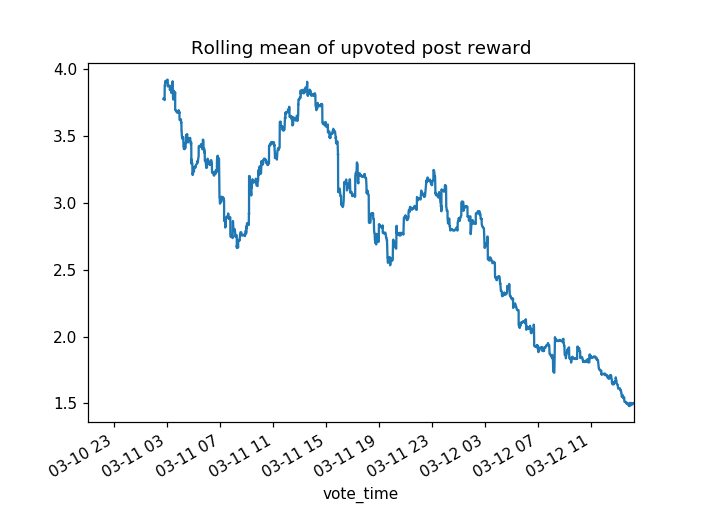

In [173]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


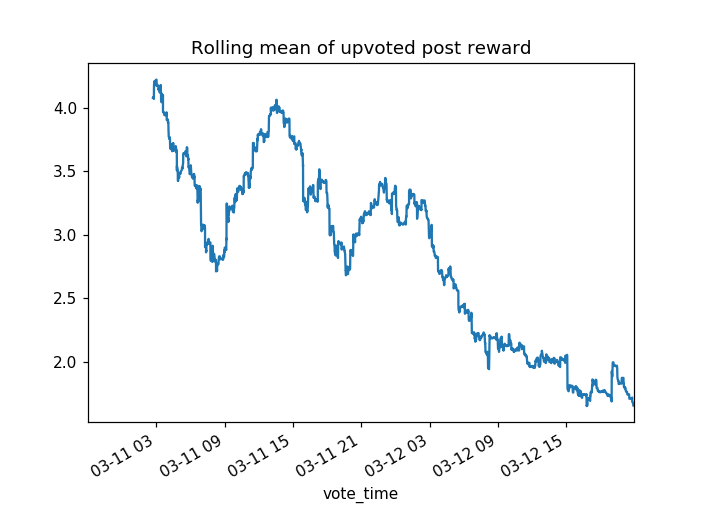

In [181]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


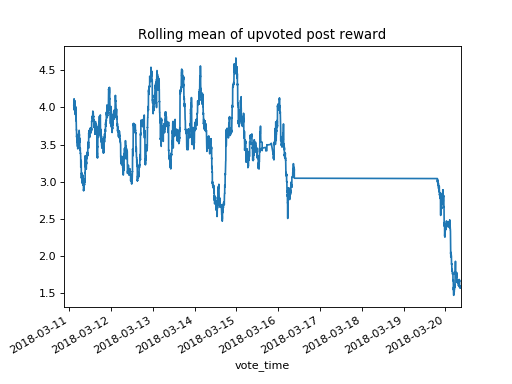

In [193]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


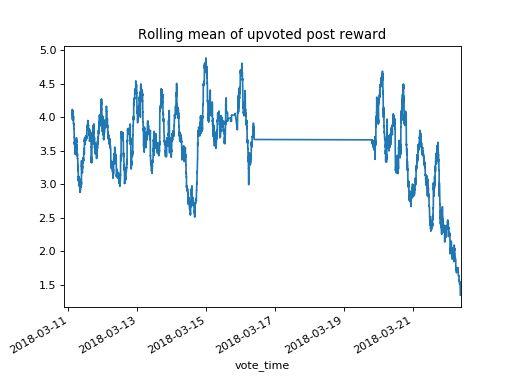

In [203]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


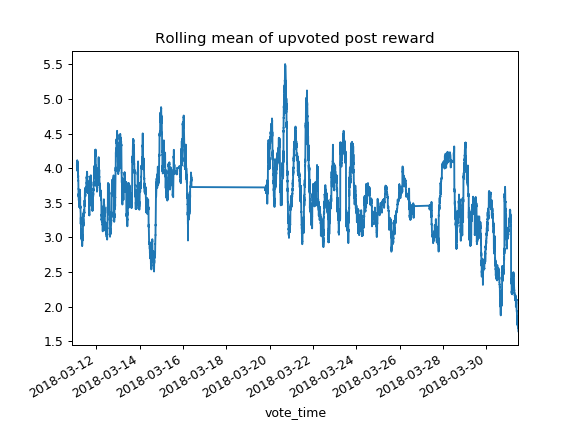

In [291]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


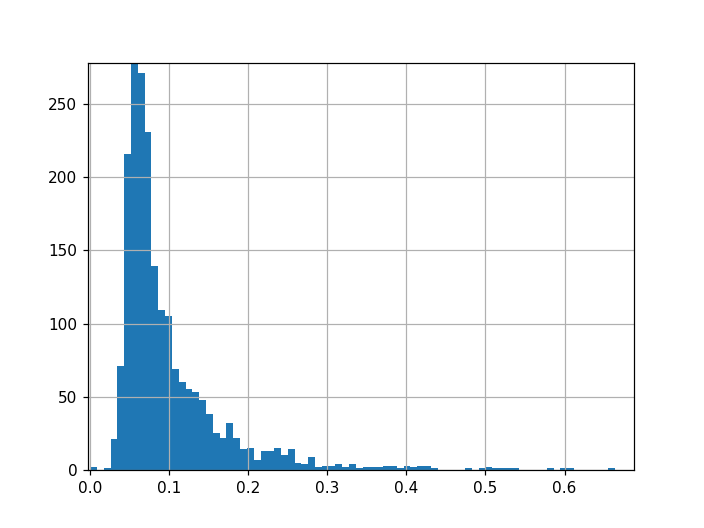

In [142]:
plt.figure()
last_week_votes_df.set_index('vote_time')['hr1_2018-03-12 14:12:56.511001'].hist(bins=100);

<IPython.core.display.Javascript object>


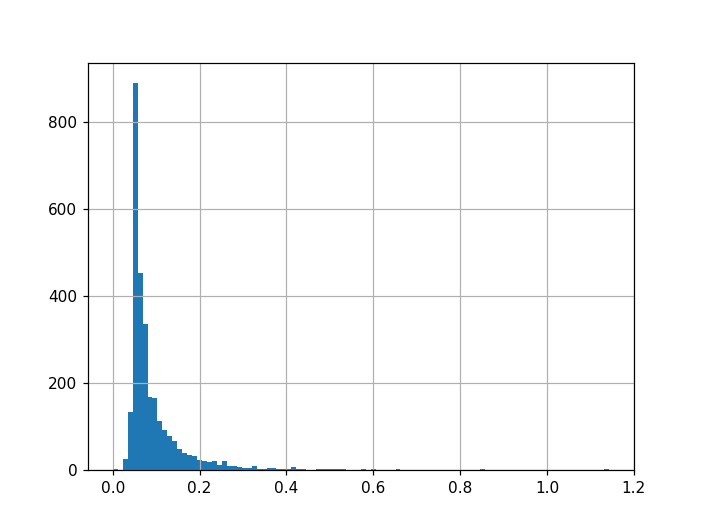

In [183]:
plt.figure()
last_week_votes_df.set_index('vote_time')['hr1_2018-03-12 20:55:44.884877'].hist(bins=100);

<IPython.core.display.Javascript object>


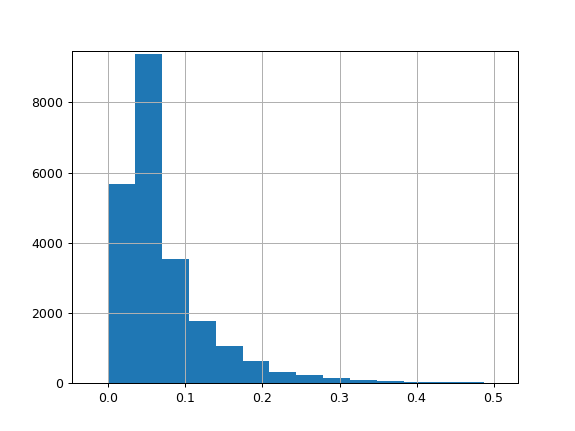

In [292]:
plt.figure()
last_week_votes_df.set_index('vote_time')['hr1_2018-03-31 13:34:06.968769'].hist(bins=100);

<IPython.core.display.Javascript object>


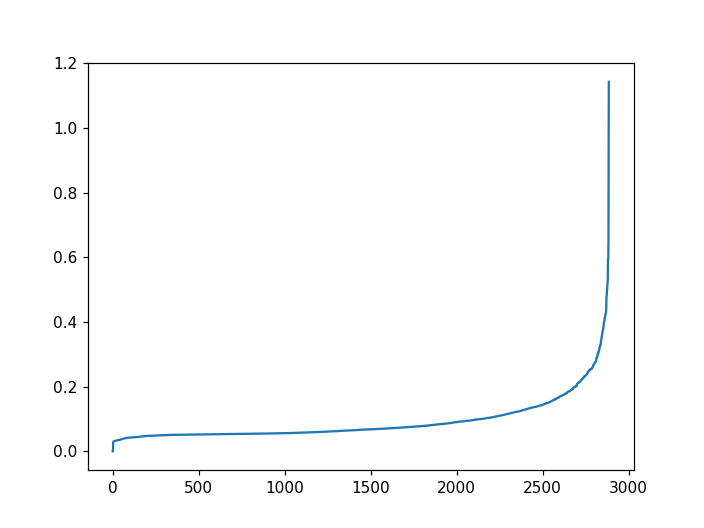

In [182]:
plt.figure()
hr1_payouts = last_week_votes_df['hr1_2018-03-12 20:55:44.884877'].sort_values().values
plt.plot(hr1_payouts);

<IPython.core.display.Javascript object>


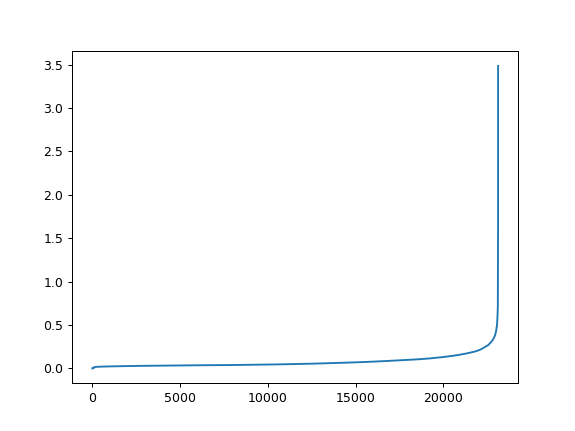

In [293]:
plt.figure()
hr1_payouts = last_week_votes_df['hr1_2018-03-31 13:34:06.968769'].sort_values().values
plt.plot(hr1_payouts);

In [149]:
last_week_votes_df.set_index('vote_time')['hr1_2018-03-12 14:12:56.511001'].mean()

0.091825239547724896

In [294]:
last_week_votes_df.set_index('vote_time')['hr1_2018-03-31 13:34:06.968769'].mean()

0.075485084851403914

#### Take the top 250 votes

In [160]:
hr1_payouts[-250:].mean()

0.2550384853716724

In [161]:
hr1_payouts[:-250].mean()

0.073633838987766417

#### Take 1/3 worst

In [169]:
hr1_payouts[:int(hr1_payouts.shape[0]/3)].mean()

0.050559492598856878

In [170]:
hr1_payouts[int(hr1_payouts.shape[0]/3):].mean()

0.11245811302215891

#### take hr1's upvote strength and multiply by curation share

- as if hr1 were the only voter

In [162]:
0.29 * 0.25

0.0725

In [165]:
last_week_votes_df[last_week_votes_df['hr1_2018-03-12 14:12:56.511001'] == last_week_votes_df['hr1_2018-03-12 14:12:56.511001'].max()]

,_id,net_votes,pending_payout_value,probability,vote_time,strength,hr1_2018-03-12 14:12:56.511001,pending,total_payout
2034,@knoxman/get-more-distance-when-casting-tips,3,"{'amount': 0.12, 'asset': 'SBD'}",0.628595,2018-03-11 20:02:22.153,2,0.86196,True,52.187


### Total rewards of current model

In [19]:
get_payout_stats(last_week_votes_df)

Total payout in given period (19.3d): 2727.423 SBD
Avg. daily payout: 141.178 SBD
Avg. weekly payout: 988.243 SBD
Avg. monthly (28d) payout: 3952.972 SBD
Avg. yearly (364d) payout: 47435.669 SBD


In [61]:
get_payout_stats(last_week_votes_df)

Total payout in given period (1.7d): 326.420 SBD
Avg. daily payout: 195.581 SBD
Avg. weekly payout: 1369.070 SBD
Avg. monthly (28d) payout: 5476.280 SBD
Avg. yearly (364d) payout: 65715.361 SBD


In [13]:
get_payout_stats(last_week_votes_df)

2018-01-24 11:02:14.292086 

Total payout in given period (2.0d): 434.093 SBD
Avg. daily payout: 213.063 SBD
Avg. weekly payout: 1491.440 SBD
Avg. monthly (28d) payout: 5965.759 SBD
Avg. yearly (364d) payout: 71589.103 SBD


In [40]:
get_payout_stats(last_week_votes_df)

2018-01-27 11:38:11.645900 

Total payout in given period (5.0d): 1537.994 SBD
Avg. daily payout: 306.144 SBD
Avg. weekly payout: 2143.006 SBD
Avg. monthly (28d) payout: 8572.024 SBD
Avg. yearly (364d) payout: 102864.291 SBD


In [40]:
get_payout_stats(last_week_votes_df)

2018-03-03 13:10:13.822957 

Total payout in given period (2.4d): 409.692 SBD
Avg. daily payout: 167.852 SBD
Avg. weekly payout: 1174.964 SBD
Avg. monthly (28d) payout: 4699.855 SBD
Avg. yearly (364d) payout: 56398.262 SBD


In [89]:
get_payout_stats(last_week_votes_df)

2018-03-03 13:50:30.982701 

Total payout in given period (2.5d): 506.522 SBD 	 (avg. upvoted post payout: 1.383)
Avg. daily payout: 201.536 SBD
Avg. weekly payout: 1410.749 SBD
Avg. monthly (28d) payout: 5642.996 SBD
Avg. yearly (364d) payout: 67715.951 SBD


In [108]:
get_payout_stats(last_week_votes_df)

2018-03-05 16:53:52.591682 

Total payout in given period (3.0d): 1025.081 SBD 	 (avg. upvoted post payout: 2.083)
Avg. daily payout: 347.287 SBD
Avg. weekly payout: 2431.011 SBD
Avg. monthly (28d) payout: 9724.045 SBD
Avg. yearly (364d) payout: 116688.541 SBD


In [123]:
get_payout_stats(last_week_votes_df)

2018-03-09 20:52:54.109058 

Total payout in given period (3.0d): 916.936 SBD 	 (avg. upvoted post payout: 2.236)
Avg. daily payout: 310.649 SBD
Avg. weekly payout: 2174.543 SBD
Avg. monthly (28d) payout: 8698.172 SBD
Avg. yearly (364d) payout: 104378.061 SBD


In [145]:
get_payout_stats(last_week_votes_df)

2018-03-12 15:27:18.021438 

Total payout in given period (1.7d): 228.920 SBD 	 (avg. upvoted post payout: 2.768)
Avg. daily payout: 133.342 SBD
Avg. weekly payout: 933.396 SBD
Avg. monthly (28d) payout: 3733.586 SBD
Avg. yearly (364d) payout: 44803.028 SBD


In [194]:
get_payout_stats(last_week_votes_df)

2018-03-22 08:57:31.021412 

Total payout in given period (9.5d): 693.542 SBD 	 (avg. upvoted post payout: 3.410)
Avg. daily payout: 73.035 SBD
Avg. weekly payout: 511.246 SBD
Avg. monthly (28d) payout: 2044.982 SBD
Avg. yearly (364d) payout: 24539.788 SBD


In [204]:
get_payout_stats(last_week_votes_df)

2018-03-22 09:41:24.042585 

Total payout in given period (11.5d): 1010.436 SBD 	 (avg. upvoted post payout: 3.477)
Avg. daily payout: 87.849 SBD
Avg. weekly payout: 614.942 SBD
Avg. monthly (28d) payout: 2459.767 SBD
Avg. yearly (364d) payout: 29517.206 SBD


In [295]:
get_payout_stats(last_week_votes_df)

2018-03-31 15:53:15.218417 

Total payout in given period (20.6d): 1745.819 SBD 	 (avg. upvoted post payout: 3.547)
Avg. daily payout: 84.725 SBD
Avg. weekly payout: 593.074 SBD
Avg. monthly (28d) payout: 2372.297 SBD
Avg. yearly (364d) payout: 28467.566 SBD


In [10]:
158.519 / 3.4

46.62323529411765

In [124]:
last_week_votes_df.shape[0] / 3

3100.6666666666665

In [126]:
last_week_votes_df.shape[0] * 2.236 / 3

6933.090666666667

### Only paid out rewards

In [62]:
get_payout_stats(last_week_votes_df, pending=False)

Total payout in given period (nand): 0.000 SBD
Avg. daily payout: nan SBD
Avg. weekly payout: nan SBD
Avg. monthly (28d) payout: nan SBD
Avg. yearly (364d) payout: nan SBD


In [195]:
get_payout_stats(last_week_votes_df, pending=False)

2018-03-22 08:58:00.713848 

Total payout in given period (2.5d): 280.649 SBD 	 (avg. upvoted post payout: 3.669)
Avg. daily payout: 111.131 SBD
Avg. weekly payout: 777.919 SBD
Avg. monthly (28d) payout: 3111.675 SBD
Avg. yearly (364d) payout: 37340.099 SBD


In [296]:
get_payout_stats(last_week_votes_df, pending=False)

2018-03-31 15:53:32.492357 

Total payout in given period (13.7d): 1203.189 SBD 	 (avg. upvoted post payout: 3.769)
Avg. daily payout: 87.685 SBD
Avg. weekly payout: 613.796 SBD
Avg. monthly (28d) payout: 2455.184 SBD
Avg. yearly (364d) payout: 29462.206 SBD


### Only pending rewards

In [21]:
get_payout_stats(last_week_votes_df, pending=True)

Total payout in given period (19.1d): 1014.689 SBD
Avg. daily payout: 53.248 SBD
Avg. weekly payout: 372.734 SBD
Avg. monthly (28d) payout: 1490.934 SBD
Avg. yearly (364d) payout: 17891.208 SBD


In [52]:
get_payout_stats(last_week_votes_df, pending=True)

Total payout in given period (1.0d): 214.473 SBD
Avg. daily payout: 206.899 SBD
Avg. weekly payout: 1448.291 SBD
Avg. monthly (28d) payout: 5793.162 SBD
Avg. yearly (364d) payout: 69517.949 SBD


In [297]:
get_payout_stats(last_week_votes_df, pending=True)

2018-03-31 15:53:48.503996 

Total payout in given period (20.6d): 542.630 SBD 	 (avg. upvoted post payout: 3.071)
Avg. daily payout: 26.355 SBD
Avg. weekly payout: 184.488 SBD
Avg. monthly (28d) payout: 737.952 SBD
Avg. yearly (364d) payout: 8855.424 SBD


### Total rewards for votes made in last N days

In [22]:
get_payout_stats(last_week_votes_df, days=1)

Total payout in given period (1.0d): 129.092 SBD
Avg. daily payout: 130.291 SBD
Avg. weekly payout: 912.039 SBD
Avg. monthly (28d) payout: 3648.156 SBD
Avg. yearly (364d) payout: 43777.868 SBD


In [63]:
get_payout_stats(last_week_votes_df, days=1)

Total payout in given period (1.0d): 168.559 SBD
Avg. daily payout: 171.005 SBD
Avg. weekly payout: 1197.034 SBD
Avg. monthly (28d) payout: 4788.135 SBD
Avg. yearly (364d) payout: 57457.615 SBD


In [14]:
get_payout_stats(last_week_votes_df, days=1)

2018-01-24 11:02:34.415241 

Total payout in given period (1.0d): 231.134 SBD
Avg. daily payout: 232.846 SBD
Avg. weekly payout: 1629.919 SBD
Avg. monthly (28d) payout: 6519.674 SBD
Avg. yearly (364d) payout: 78236.090 SBD


In [36]:
get_payout_stats(last_week_votes_df, days=1)

2018-01-27 11:36:17.510512 

Total payout in given period (1.0d): 283.883 SBD
Avg. daily payout: 283.883 SBD
Avg. weekly payout: 1987.180 SBD
Avg. monthly (28d) payout: 7948.721 SBD
Avg. yearly (364d) payout: 95384.649 SBD


In [109]:
get_payout_stats(last_week_votes_df, days=1)

2018-03-05 17:32:22.011318 

Total payout in given period (1.0d): 161.900 SBD 	 (avg. upvoted post payout: 1.517)
Avg. daily payout: 161.900 SBD
Avg. weekly payout: 1133.297 SBD
Avg. monthly (28d) payout: 4533.190 SBD
Avg. yearly (364d) payout: 54398.276 SBD


In [146]:
get_payout_stats(last_week_votes_df, days=1)

2018-03-12 15:28:19.462373 

Total payout in given period (1.0d): 112.899 SBD 	 (avg. upvoted post payout: 2.220)
Avg. daily payout: 112.899 SBD
Avg. weekly payout: 790.294 SBD
Avg. monthly (28d) payout: 3161.177 SBD
Avg. yearly (364d) payout: 37934.124 SBD


In [298]:
get_payout_stats(last_week_votes_df, days=1)

2018-03-31 15:54:23.250304 

Total payout in given period (1.0d): 79.468 SBD 	 (avg. upvoted post payout: 2.522)
Avg. daily payout: 79.468 SBD
Avg. weekly payout: 556.276 SBD
Avg. monthly (28d) payout: 2225.106 SBD
Avg. yearly (364d) payout: 26701.271 SBD


In [23]:
get_payout_stats(last_week_votes_df, days=2)

Total payout in given period (2.0d): 263.789 SBD
Avg. daily payout: 132.517 SBD
Avg. weekly payout: 927.619 SBD
Avg. monthly (28d) payout: 3710.476 SBD
Avg. yearly (364d) payout: 44525.706 SBD


In [64]:
get_payout_stats(last_week_votes_df, days=2)

Total payout in given period (1.7d): 326.420 SBD
Avg. daily payout: 195.581 SBD
Avg. weekly payout: 1369.070 SBD
Avg. monthly (28d) payout: 5476.280 SBD
Avg. yearly (364d) payout: 65715.361 SBD


In [15]:
get_payout_stats(last_week_votes_df, days=2)

2018-01-24 11:03:00.281183 

Total payout in given period (2.0d): 422.865 SBD
Avg. daily payout: 212.260 SBD
Avg. weekly payout: 1485.818 SBD
Avg. monthly (28d) payout: 5943.273 SBD
Avg. yearly (364d) payout: 71319.274 SBD


In [37]:
get_payout_stats(last_week_votes_df, days=2)

2018-01-27 11:36:35.489545 

Total payout in given period (2.0d): 653.360 SBD
Avg. daily payout: 326.680 SBD
Avg. weekly payout: 2286.761 SBD
Avg. monthly (28d) payout: 9147.044 SBD
Avg. yearly (364d) payout: 109764.528 SBD


In [147]:
get_payout_stats(last_week_votes_df, days=2)

2018-03-12 15:28:44.870036 

Total payout in given period (1.8d): 228.920 SBD 	 (avg. upvoted post payout: 2.768)
Avg. daily payout: 129.184 SBD
Avg. weekly payout: 904.289 SBD
Avg. monthly (28d) payout: 3617.155 SBD
Avg. yearly (364d) payout: 43405.859 SBD


In [299]:
get_payout_stats(last_week_votes_df, days=2)

2018-03-31 15:54:30.692817 

Total payout in given period (2.0d): 205.962 SBD 	 (avg. upvoted post payout: 2.619)
Avg. daily payout: 102.981 SBD
Avg. weekly payout: 720.866 SBD
Avg. monthly (28d) payout: 2883.466 SBD
Avg. yearly (364d) payout: 34601.591 SBD


In [24]:
get_payout_stats(last_week_votes_df, days=3)

Total payout in given period (3.0d): 395.534 SBD
Avg. daily payout: 132.224 SBD
Avg. weekly payout: 925.571 SBD
Avg. monthly (28d) payout: 3702.286 SBD
Avg. yearly (364d) payout: 44427.431 SBD


In [44]:
get_payout_stats(last_week_votes_df, days=3)

2018-01-27 11:44:04.014245 

Total payout in given period (3.0d): 821.864 SBD
Avg. daily payout: 273.955 SBD
Avg. weekly payout: 1917.682 SBD
Avg. monthly (28d) payout: 7670.729 SBD
Avg. yearly (364d) payout: 92048.748 SBD


In [300]:
get_payout_stats(last_week_votes_df, days=3)

2018-03-31 15:54:37.506852 

Total payout in given period (3.0d): 342.763 SBD 	 (avg. upvoted post payout: 2.905)
Avg. daily payout: 114.254 SBD
Avg. weekly payout: 799.781 SBD
Avg. monthly (28d) payout: 3199.123 SBD
Avg. yearly (364d) payout: 38389.472 SBD


In [25]:
get_payout_stats(last_week_votes_df, days=7)

Total payout in given period (7.0d): 1017.376 SBD
Avg. daily payout: 145.535 SBD
Avg. weekly payout: 1018.745 SBD
Avg. monthly (28d) payout: 4074.981 SBD
Avg. yearly (364d) payout: 48899.773 SBD


In [43]:
get_payout_stats(last_week_votes_df, days=7)

2018-01-27 11:43:39.504763 

Total payout in given period (5.1d): 1537.994 SBD
Avg. daily payout: 303.150 SBD
Avg. weekly payout: 2122.051 SBD
Avg. monthly (28d) payout: 8488.204 SBD
Avg. yearly (364d) payout: 101858.449 SBD


In [301]:
get_payout_stats(last_week_votes_df, days=7)

2018-03-31 15:54:43.102774 

Total payout in given period (7.0d): 538.744 SBD 	 (avg. upvoted post payout: 3.090)
Avg. daily payout: 76.963 SBD
Avg. weekly payout: 538.744 SBD
Avg. monthly (28d) payout: 2154.974 SBD
Avg. yearly (364d) payout: 25859.692 SBD
